In [1]:
%load_ext jupyternotify

# import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit
import joblib
import utils

from tqdm.auto import tqdm
# from scipy.stats import *

pd.set_option('display.max_columns', None)

<IPython.core.display.Javascript object>

In [2]:
import importlib
# importlib.reload(utils)

In [3]:
# pd.set_option('display.max_colwidth', None)

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [5]:
# data_df_1522 = pd.read_csv('../data/PitchDataCleanedLean_15-22.csv', index_col=[0])
# data_train_df = data_df_1522[data_df_1522['game_year'].isin([2015, 2016, 2017, 2018])].copy()
# data_test_df = data_df_1522[data_df_1522['game_year']==2019].copy()

In [6]:
### Load Transition Matrices ###
T_batters_dict_1518 = joblib.load('T_batters_dict_1518')
T_pitchers_dict_1518 = joblib.load('T_pitchers_dict_1518')

pitcher_quali_list = list(T_pitchers_dict_1518.keys())
batter_quali_list = list(T_batters_dict_1518.keys())

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
pa_data_1519 = pd.read_csv('../data/PA_data_merged_15-19_012323.csv', index_col=[0])
# remove 'other'
pa_data_1519 = pa_data_1519[pa_data_1519['event_type']!='other'].copy()

In [10]:
### Train/Val/Test Split ###
train_val_df = pa_data_1519[pa_data_1519['game_year'].isin([2015, 2016, 2017, 2018])].copy()
train_val_df = train_val_df[(train_val_df['pitcher'].isin(pitcher_quali_list))&(train_val_df['batter'].isin(batter_quali_list))].copy()
test_df = pa_data_1519[pa_data_1519['game_year']==2019].copy()
test_df = test_df[(test_df['pitcher'].isin(pitcher_quali_list))&(test_df['batter'].isin(batter_quali_list))].copy()

train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=0, shuffle=True)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"train size: {train_df.shape}")
print(f"val size: {val_df.shape}")
print(f"test size: {test_df.shape}")

train size: (434677, 36)
val size: (108670, 36)
test size: (83464, 36)


In [11]:
# create matchup lists to loop through later
train_matchup_list = list(zip(train_df['pitcher'], train_df['batter']))
val_matchup_list = list(zip(val_df['pitcher'], val_df['batter']))
test_matchup_list = list(zip(test_df['pitcher'], test_df['batter']))

In [12]:
### Encode Target Variables ###
y_train = train_df['event_type'].values
y_val = val_df['event_type'].values
y_test = test_df['event_type'].values

y_train_factor = pd.factorize(train_df['event_type'].values)[0]
y_val_factor = pd.factorize(val_df['event_type'].values)[0]
y_test_factor = pd.factorize(test_df['event_type'].values)[0]

y_train_binary = train_df[utils.EVENT_LIST].values
y_val_binary = val_df[utils.EVENT_LIST].values
y_test_binary = test_df[utils.EVENT_LIST].values

# Random Forest T matrix as X

In [11]:
import itertools

# create feature names
feature_names = list(itertools.product(utils.COUNT_LIST_STR, utils.COUNT_LIST_STR + utils.EVENT_LIST))
feature_names = [f[0]+'-'+f[1] for f in feature_names]
feature_names = np.array(feature_names)[np.array(utils.MASTER_MAP).flatten()]
p_feature_names = ['pitcher-'+f for f in feature_names]
b_feature_names = ['batter-'+f for f in feature_names]
feature_names = np.array(p_feature_names + b_feature_names)


T_batters_RF_1518 = {}
for key, item in tqdm(T_batters_dict_1518.items()):
    T_batter_long = []
    for i in range(12):
        T_count = item[i][utils.MASTER_MAP[i]].tolist()
        T_batter_long+=T_count
    T_batters_RF_1518[key] = T_batter_long

T_pitchers_RF_1518 = {}
for key, item in tqdm(T_pitchers_dict_1518.items()):
    T_pitcher_long = []
    for i in range(12):
        T_count = item[i][utils.MASTER_MAP[i]].tolist()
        T_pitcher_long+=T_count
    T_pitchers_RF_1518[key] = T_pitcher_long
    
# # dump dict
# joblib.dump(T_batters_RF_1518, 'T_batters_RF_1518')
# joblib.dump(T_pitchers_RF_1518, 'T_pitchers_RF_1518')

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

In [16]:
# ### Load RF transition matrices ###
# T_batters_RF_1518 = joblib.load('T_batters_RF_1518')
# T_pitchers_RF_1518 = joblib.load('T_pitchers_RF_1518')

In [12]:
X_train = []
for train_matchup in tqdm(train_matchup_list):
    pitcher = train_matchup[0]
    batter = train_matchup[1]

    X_row = np.concatenate([T_pitchers_RF_1518[pitcher], T_batters_RF_1518[batter]]).tolist()
    X_train+=[X_row]
X_train = np.array(X_train)
    
X_val = []
for val_matchup in tqdm(val_matchup_list):
    pitcher = val_matchup[0]
    batter = val_matchup[1]

    X_row = np.concatenate([T_pitchers_RF_1518[pitcher], T_batters_RF_1518[batter]]).tolist()
    X_val+=[X_row]    
X_val = np.array(X_val)

X_test = []
for test_matchup in tqdm(test_matchup_list):
    pitcher = test_matchup[0]
    batter = test_matchup[1]

    X_row = np.concatenate([T_pitchers_RF_1518[pitcher], T_batters_RF_1518[batter]]).tolist()
    X_test+=[X_row]
X_test = np.array(X_test)

  0%|          | 0/434677 [00:00<?, ?it/s]

  0%|          | 0/108670 [00:00<?, ?it/s]

  0%|          | 0/83464 [00:00<?, ?it/s]

In [13]:
# create X df with column names to make easy for feature selection
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

train_df = pd.concat([train_df, X_train_df], axis=1)
val_df = pd.concat([val_df, X_val_df], axis=1)
test_df = pd.concat([test_df, X_test_df], axis=1)

### Default RF Model

In [19]:
clf = RandomForestClassifier(random_state=0, n_jobs=5)

model_rf_default = clf.fit(X_train, y_train)
y_pred_rf_uncal = model_rf_default.predict_proba(X_test)
print(f"RF Uncal: {utils.get_brier_score(y_test_binary, y_pred_rf_uncal):4f}")

model_rf_default_cal = CalibratedClassifierCV(model_rf_default, method='isotonic', cv=5, n_jobs=5)
model_rf_default_cal.fit(X_val, y_val)
y_pred_rf_cal = model_rf_default_cal.predict_proba(X_test)
print(f"RF cal: {utils.get_brier_score(y_test_binary, y_pred_rf_cal):4f}")

RF Uncal: 0.831067


### Results:

RF default uncal: 0.831067

RF default cal: 0.714180

# PCA

In [17]:
# Import required libraries
from sklearn.decomposition import PCA

In [27]:
pca = PCA()
pca.fit(X_train)

PCA()

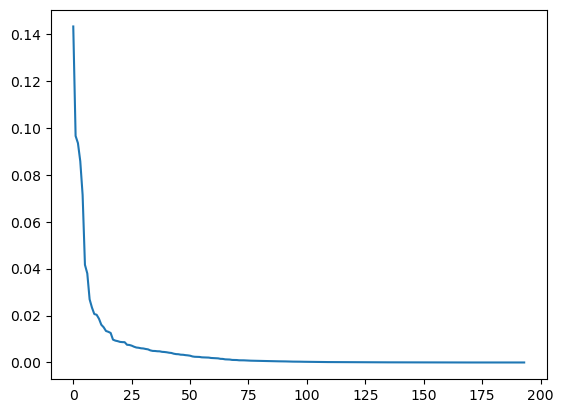

In [28]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [18]:
pca = PCA(n_components=25)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [51]:
clf = RandomForestClassifier(random_state=0, n_jobs=5)
clf_pca_T = clf.fit(X_train_pca, y_train)
y_pred_pca_uncal = clf_pca_T.predict_proba(X_test_pca)
print(f"T Uncal: {utils.get_brier_score(y_test_binary, y_pred_pca_uncal):4f}")

T Uncal: 0.807538


In [52]:
clf_calibrated_pca = CalibratedClassifierCV(clf_pca_T, method='isotonic', cv=5, n_jobs=5)
clf_calibrated_pca.fit(X_val_pca, y_val)
y_pred_pca_cal = clf_calibrated_pca.predict_proba(X_test_pca)
print(f"P, cal: {utils.get_brier_score(y_test_binary, y_pred_pca_cal):4f}")

P, cal: 0.714280


In [33]:
for n_components in tqdm([15, 20, 25, 30, 45]):
    print(f"N Components: {n_components}")
    pca = PCA(n_components=n_components, random_state=0)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)

    clf = RandomForestClassifier(random_state=0, n_jobs=5)
    model_rf_pca = clf.fit(X_train_pca, y_train)
    y_pred_rf_pca_uncal = model_rf_pca.predict_proba(X_test_pca)
    print(f"PCA Uncal: {utils.get_brier_score(y_test_binary, y_pred_rf_pca_uncal):4f}")

    model_rf_pca_cal = CalibratedClassifierCV(model_rf_pca, method='isotonic', cv=5, n_jobs=5)
    model_rf_pca_cal.fit(X_val_pca, y_val)
    y_pred_rf_pca_cal = model_rf_pca_cal.predict_proba(X_test_pca)
    print(f"PCA Cal: {utils.get_brier_score(y_test_binary, y_pred_rf_pca_cal):4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

N Components: 15
PCA Uncal: 0.827524
PCA Cal: 0.714395
N Components: 20
PCA Uncal: 0.800912
PCA Cal: 0.714352
N Components: 25
PCA Uncal: 0.806961
PCA Cal: 0.714277
N Components: 30
PCA Uncal: 0.808137
PCA Cal: 0.714230
N Components: 45
PCA Uncal: 0.815322
PCA Cal: 0.714275


### Results: 

###### PCA(n_components=15):

Uncal: 0.827524

Cal: 0.714395

###### PCA(n_components=20):

Uncal: 0.800912

Cal: 0.714352

###### PCA(n_components=25):

Uncal: 0.806961

Cal: 0.714277

###### PCA(n_components=30):

Uncal: 0.808137

Cal: 0.714230

###### PCA(n_components=45):

Uncal: 0.815322

Cal: 0.714275

# Std Scale

In [14]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

In [ ]:
pca_std = PCA(n_components=20, random_state=0)
X_train_std_pca = pca_std.fit_transform(X_train_std)
X_val_std_pca = pca_std.transform(X_val_std)
X_test_std_pca = pca_std.transform(X_test_std)

clf = RandomForestClassifier(random_state=0, n_jobs=5)
model_rf_std_pca_uncal = clf.fit(X_train_std_pca, y_train)
y_pred_rf_std_pca_uncal = model_rf_std_pca_uncal.predict_proba(X_test_std_pca)
print(f"RF PCA STD Uncal: {utils.get_brier_score(y_test_binary, y_pred_rf_std_pca_uncal):4f}")

model_rf_std_pca_cal = CalibratedClassifierCV(model_rf_std_pca_uncal, method='isotonic', cv=5, n_jobs=5)
model_rf_std_pca_cal.fit(X_val_std_pca, y_val)
y_pred_rf_std_pca_cal = model_rf_std_pca_cal.predict_proba(X_test_std_pca)
print(f"T PCA STD Cal: {utils.get_brier_score(y_test_binary, y_pred_rf_std_pca_cal):4f}")

### Results: 

###### STD PCA(n_components=25):

Uncal: 0.774887

Cal: 0.714138

# CaliForest

In [20]:
from califorest import CaliForest

## Without PCA

In [170]:
# Single
model_b1_califorest = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_b1_califorest.fit(X_train_T, y_train_binary[:, 0])
y_pred_b1_califorest = model_b1_califorest.predict_proba(X_test_T)[:, 1]

CaliForest(max_depth=None, n_estimators=100)

In [174]:
# Double
model_b2_califorest = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_b2_califorest.fit(X_train_T, y_train_binary[:, 1])
y_pred_b2_califorest = model_b2_califorest.predict_proba(X_test_T)[:, 1]

CaliForest(max_depth=None, n_estimators=100)

In [204]:
np.unique(y_pred_b2_califorest, return_counts=True)

(array([0.04518907, 0.0452027 , 0.04755319, 0.04820048, 0.05560014]),
 array([52231, 15889,   161, 15170,    13]))

In [217]:
# Triple
model_b3_califorest = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_b3_califorest.fit(X_train_T, y_train_binary[:, 2])
y_pred_b3_califorest = model_b3_califorest.predict_proba(X_test_T)[:, 1]

CaliForest(max_depth=None, n_estimators=100)

In [220]:
# check unique prediction values
np.unique(y_pred_b3_califorest, return_counts=True)

(array([0.00445217, 0.00611645, 0.00620312, 0.00819967, 0.00940265,
        0.00975874, 0.00998284, 0.01131834, 0.01268891, 0.01775535]),
 array([61021,  4791, 16918,     7,   137,     4,   406,     1,   153,
           26]))

In [236]:
# Homerun
model_hr_califorest = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_hr_califorest.fit(X_train_T, y_train_binary[:, 3])
y_pred_hr_califorest = model_hr_califorest.predict_proba(X_test_T)[:, 1]

CaliForest(max_depth=None, n_estimators=100)

In [239]:
# Fieldout
model_fo_califorest = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_fo_califorest.fit(X_train_T, y_train_binary[:, 4])
y_pred_fo_califorest = model_fo_califorest.predict_proba(X_test_T)[:, 1]

CaliForest(max_depth=None, n_estimators=100)

In [251]:
# Walk
model_bb_califorest = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_bb_califorest.fit(X_train_T, y_train_binary[:, 5])
y_pred_bb_califorest = model_bb_califorest.predict_proba(X_test_T)[:, 1]

CaliForest(max_depth=None, n_estimators=100)

In [252]:
# Strikeout
model_k_califorest = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_k_califorest.fit(X_train_T, y_train_binary[:, 6])
y_pred_k_califorest = model_k_califorest.predict_proba(X_test_T)[:, 1]

CaliForest(max_depth=None, n_estimators=100)

In [273]:
y_pred_all_califorest = np.concatenate([
    np.expand_dims(y_pred_b1_califorest, axis=1),
    np.expand_dims(y_pred_b2_califorest, axis=1),
    np.expand_dims(y_pred_b3_califorest, axis=1),
    np.expand_dims(y_pred_hr_califorest, axis=1),
    np.expand_dims(y_pred_fo_califorest, axis=1),
    np.expand_dims(y_pred_bb_califorest, axis=1),
    np.expand_dims(y_pred_k_califorest, axis=1)
], axis=1)
# normalize probability to 1:
y_pred_all_califorest = utils.normalize_arr(y_pred_all_califorest)

In [345]:
# Califorest, no PCA, One model for each class, default params
print(f"Califorest B Score: {utils.get_brier_score(y_test_binary, y_pred_all_califorest)}")

Califorest B Score: 0.7082242879762285


### Results:
#### Califorest, no PCA, 1 model for each class, default params: 0.7082242879762285

## With PCA

In [22]:
# Single
model_b1_califorest_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_b1_califorest_pca.fit(X_train_pca, y_train_binary[:, 0])
y_pred_b1_califorest_pca = model_b1_califorest_pca.predict_proba(X_test_pca)[:, 1]

In [26]:
# Double
model_b2_califorest_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_b2_califorest_pca.fit(X_train_pca, y_train_binary[:, 1])
y_pred_b2_califorest_pca = model_b2_califorest_pca.predict_proba(X_test_pca)[:, 1]

In [27]:
# Triple
model_b3_califorest_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_b3_califorest_pca.fit(X_train_pca, y_train_binary[:, 2])
y_pred_b3_califorest_pca = model_b3_califorest_pca.predict_proba(X_test_pca)[:, 1]

In [28]:
# Homerun
model_hr_califorest_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_hr_califorest_pca.fit(X_train_pca, y_train_binary[:, 3])
y_pred_hr_califorest_pca = model_hr_califorest_pca.predict_proba(X_test_pca)[:, 1]

In [29]:
# Fieldout
model_fo_califorest_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_fo_califorest_pca.fit(X_train_pca, y_train_binary[:, 4])
y_pred_fo_califorest_pca = model_fo_califorest_pca.predict_proba(X_test_pca)[:, 1]

In [30]:
# Walk
model_bb_califorest_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_bb_califorest_pca.fit(X_train_pca, y_train_binary[:, 5])
y_pred_bb_califorest_pca = model_bb_califorest_pca.predict_proba(X_test_pca)[:, 1]

In [32]:
# Strikeout
model_k_califorest_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_k_califorest_pca.fit(X_train_pca, y_train_binary[:, 6])
y_pred_k_califorest_pca = model_k_califorest_pca.predict_proba(X_test_pca)[:, 1]

In [34]:
y_pred_califorest_pca = np.concatenate([
    np.expand_dims(y_pred_b1_califorest_pca, axis=1),
    np.expand_dims(y_pred_b2_califorest_pca, axis=1),
    np.expand_dims(y_pred_b3_califorest_pca, axis=1),
    np.expand_dims(y_pred_hr_califorest_pca, axis=1),
    np.expand_dims(y_pred_fo_califorest_pca, axis=1),
    np.expand_dims(y_pred_bb_califorest_pca, axis=1),
    np.expand_dims(y_pred_k_califorest_pca, axis=1)
], axis=1)
# normalize probability to 1:
y_pred_califorest_pca = utils.normalize_arr(y_pred_califorest_pca)

In [35]:
# Califorest, no PCA, One model for each class, default params
print(f"Califorest B Score: {utils.get_brier_score(y_test_binary, y_pred_califorest_pca)}")

Califorest B Score: 0.7081221348261737


# STD PCA

In [40]:
start = time.time()

In [41]:
# Single
model_b1_califorest_std_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_b1_califorest_std_pca.fit(X_train_std_pca, y_train_binary[:, 0])
y_pred_b1_califorest_std_pca = model_b1_califorest_std_pca.predict_proba(X_test_std_pca)[:, 1]

# Double
model_b2_califorest_std_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_b2_califorest_std_pca.fit(X_train_std_pca, y_train_binary[:, 1])
y_pred_b2_califorest_std_pca = model_b2_califorest_std_pca.predict_proba(X_test_std_pca)[:, 1]

# Triple
model_b3_califorest_std_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_b3_califorest_std_pca.fit(X_train_std_pca, y_train_binary[:, 2])
y_pred_b3_califorest_std_pca = model_b3_califorest_std_pca.predict_proba(X_test_std_pca)[:, 1]

# Homerun
model_hr_califorest_std_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_hr_califorest_std_pca.fit(X_train_std_pca, y_train_binary[:, 3])
y_pred_hr_califorest_std_pca = model_hr_califorest_std_pca.predict_proba(X_test_std_pca)[:, 1]

# Fieldout
model_fo_califorest_std_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_fo_califorest_std_pca.fit(X_train_std_pca, y_train_binary[:, 4])
y_pred_fo_califorest_std_pca = model_fo_califorest_std_pca.predict_proba(X_test_std_pca)[:, 1]

# Walk
model_bb_califorest_std_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_bb_califorest_std_pca.fit(X_train_std_pca, y_train_binary[:, 5])
y_pred_bb_califorest_std_pca = model_bb_califorest_std_pca.predict_proba(X_test_std_pca)[:, 1]

# Strikeout
model_k_califorest_std_pca = CaliForest(n_estimators=100,
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    ctype="isotonic")
model_k_califorest_std_pca.fit(X_train_std_pca, y_train_binary[:, 6])
y_pred_k_califorest_std_pca = model_k_califorest_std_pca.predict_proba(X_test_std_pca)[:, 1]

y_pred_califorest_std_pca = np.concatenate([
    np.expand_dims(y_pred_b1_califorest_std_pca, axis=1),
    np.expand_dims(y_pred_b2_califorest_std_pca, axis=1),
    np.expand_dims(y_pred_b3_califorest_std_pca, axis=1),
    np.expand_dims(y_pred_hr_califorest_std_pca, axis=1),
    np.expand_dims(y_pred_fo_califorest_std_pca, axis=1),
    np.expand_dims(y_pred_bb_califorest_std_pca, axis=1),
    np.expand_dims(y_pred_k_califorest_std_pca, axis=1)
], axis=1)
# normalize probability to 1:
y_pred_califorest_std_pca = utils.normalize_arr(y_pred_califorest_std_pca)

# Califorest, no PCA, One model for each class, default params
print(f"Califorest B Score: {utils.get_brier_score(y_test_binary, y_pred_califorest_std_pca)}")

Califorest B Score: 0.7078940880695483


STD PCA Califorest B Score: 0.7078940880695483

In [42]:
time.time() - start

1583.8940210342407